# EasyMoney: haz realidad tus sueños sin complicaciones

# 1

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as plotly

from plotly.subplots import make_subplots

plt.style.use("seaborn-pastel")

from datetime import datetime

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os

## Import data

In [3]:
commercial_df = pd.read_csv("../data/raw/commercial_activity_df.csv", sep=",")
products_df = pd.read_csv("../data/raw/products_df.csv", sep=",")
sociodemographic_df = pd.read_csv("../data/raw/sociodemographic_df.csv", sep=",")

## Unificar data

In [4]:
df_1 = pd.merge(left=commercial_df, right=sociodemographic_df, how="inner", on=["pk_cid", "pk_partition"])
df = pd.merge(left=df_1, right=products_df, how="inner", on=["pk_cid", "pk_partition"])

In [5]:
df.head()

,Unnamed: 0_x,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,Unnamed: 0_y,country_id,region_code,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,ES,29.0,...,0,0,0,0.0,0.0,0,0,0,0,1
1,1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,1,ES,13.0,...,0,0,0,0.0,0.0,0,0,0,0,1
2,2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,2,ES,13.0,...,0,0,0,0.0,0.0,0,0,0,0,1
3,3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,3,ES,50.0,...,0,0,0,0.0,0.0,0,0,0,0,0
4,4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,4,ES,50.0,...,0,0,0,0.0,0.0,0,0,0,0,1


## Transformar fechas

In [6]:
#Obteníamos un error al convertir nuestra variable a fecha debido a las fechas correspondientes al 29 de Febrero de los años 2015 y 2019 puesto que no existen.Por este motivo, decidimos reemplazar estos valores por la fecha más cercana (día anterior)
df["entry_date"] = df["entry_date"].replace("2015-02-29", "2015-02-28")
df["entry_date"] = df["entry_date"].replace("2019-02-29", "2019-02-28")

In [7]:
#Convertimos nuestra variable a "fecha" mediante el pd.to_datetime
df["entry_date"] = pd.to_datetime(df["entry_date"])

In [8]:
#Generamos atributos extras a partir de pk_partition
df['entry_date_Month'] = df['entry_date'].dt.month.astype(int)
df['entry_date_Year'] = df['entry_date'].dt.year.astype(int)
df['entry_date_Week'] = df['entry_date'].dt.week.astype(int)
df['entry_date_Weekday'] = df['entry_date'].dt.weekday.astype(int)
df['entry_date_Trim'] = df['entry_date'].dt.quarter.astype(int)

C:\Users\alfre\AppData\Local\Temp/ipykernel_18184/3362508110.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['entry_date_Week'] = df['entry_date'].dt.week.astype(int)


In [9]:
#Convertimos nuestra variable a "fecha" mediante el pd.to_datetime
df["pk_partition"] = pd.to_datetime(df["pk_partition"])

In [10]:
#Generamos atributos extras a partir de pk_partition
df['pk_partition_Month'] = df['pk_partition'].dt.month.astype(int)
df['pk_partition_Year'] = df['pk_partition'].dt.year.astype(int)
df['pk_partition_Week'] = df['pk_partition'].dt.week.astype(int)
df['pk_partition_Weekday'] = df['pk_partition'].dt.weekday.astype(int)
df['pk_partition_Trim'] = df['pk_partition'].dt.quarter.astype(int)

C:\Users\alfre\AppData\Local\Temp/ipykernel_18184/1501619623.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['pk_partition_Week'] = df['pk_partition'].dt.week.astype(int)


## Exploratory Data Analysis

Para facilitar el análisis exploratorio univariantes de los datos, a pesar de tener un dataset unificado llamado df, analizaremos los datos dividiéndolos por:

*   Commercial_df
*   Products_df
*   Sociodemographic_df

De esta manera, podremos facilitar el entendimiento del notebook dotándolo de una mejor estructura.


### Definición de funciones

#### Función para graficar los nulos

In [11]:
def graficar(dataframe):
    #creamos un dataframe para los nulos
    df_nulos = dataframe.isnull().sum().reset_index(name="Num_Nulos")
    df_nulos = df_nulos[df_nulos["Num_Nulos"] > 0].sort_values(by="Num_Nulos", ascending=False)
    df_nulos["Porcentaje"] = (df_nulos["Num_Nulos"] / dataframe.shape[0]) * 100

    plt.figure(figsize=[10, 8])
    ax = df_nulos.plot.bar(x="index", y="Num_Nulos", rot=10)
    plt.title("Cantidad de Nulos")
    plt.show()

    return df_nulos


#### Función de detección de atributos con baja variabilidad

Vamos a crear una función que nos permita analizar los atributos con baja variabilidad. Es decir, aquellos dónde existe un valor único que representa el 99% de las instancias y por tanto dispone de una distribución sesgada y no resulta útil para el modelo.

In [12]:
def skewness(dataframe):
    skewness_df = pd.DataFrame([{'Atributos': c, 'val_únicos': dataframe[c].nunique(),
                                 'Skewness': dataframe[c].value_counts(normalize=True).values[0] * 100} for c in
                                dataframe.columns])
    skewness_df = skewness_df.sort_values('Skewness', ascending=False)
    new_skewness = skewness_df[skewness_df["Skewness"] >= 90]
    print(new_skewness)
    return new_skewness

#### Función para seleccionar las particiones

In [13]:
def select_partition(dataframe: pd.DataFrame, from_partition: int, size: int = 1) -> pd.DataFrame:
    """
    Selecciona particiones del dataframe
    :param dataframe: dataframe a evaluar
    :param from_partition: mes de inicio a evaluar desde 1 a 17
    :param size: (optional, default=1) cantidad de particiones a mostrar
    :return: dataframe particionado
    """
    partitions = dataframe["pk_partition"].unique()
    from_partition = from_partition - 1
    to_partition = from_partition + size
    return dataframe[dataframe["pk_partition"].isin(partitions[from_partition: to_partition])]

#### Funciones de visualización 

##### Visualización de booleanas

In [14]:
def plot_bool(dataframe, column):
    plt.title(column, fontsize=14, pad=30)
    sns.countplot(data=dataframe, x=column, palette=['#FF7AA2', "#C82065"])
    plt.xlabel('')
    plt.show()

#### Funciones de exploración

##### Función de exploración de variables categóricas

##### Función de exploración de variables numéricas

##### Función de exploración de variables booleans


##### Función de exploración de variables de tipo fecha


#### Funciones para seleccionar "Others"

In [15]:
def other_selection(dataframe, column, num_values):
    top_browsers = dataframe[column].value_counts().head(num_values)
    top_browsers_list = top_browsers.index.to_list()
    top_browsers_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_browsers_list)
    return dataframe[column].fillna('Others')

### Exploración del df

<Figure size 720x576 with 0 Axes>

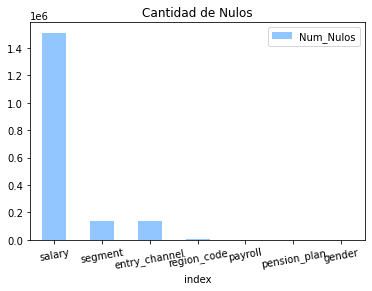

,index,Num_Nulos,Porcentaje
13,salary,1512103,25.358415
6,segment,133944,2.246281
4,entry_channel,133033,2.231003
9,region_code,2264,0.037968
23,payroll,61,0.001023
24,pension_plan,61,0.001023
10,gender,25,0.000419


In [16]:
graficar(df)

### Exploración del dataset "Commercial_df"

---



In [17]:
#El dataset no contiene atributos con baja variabilidad
skewness(commercial_df)

Empty DataFrame
Columns: [Atributos, val_únicos, Skewness]
Index: []


,Atributos,val_únicos,Skewness


In [18]:
commercial_df.head()

,Unnamed: 0,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES
1,1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO
2,2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO
3,3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO
4,4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO


In [19]:
commercial_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Columns: 7 entries, Unnamed: 0 to segment
dtypes: float64(1), int64(2), object(4)
memory usage: 318.5+ MB


In [20]:
commercial_df.describe()

,Unnamed: 0,pk_cid,active_customer
count,5.962924e+06,5.962924e+06,5.962924e+06
mean,7.155425e+06,1.234930e+06,4.033845e-01
std,3.920784e+06,1.623020e+05,4.905767e-01
min,0.000000e+00,1.589100e+04,0.000000e+00
25%,4.240386e+06,1.112532e+06,0.000000e+00
50%,7.499346e+06,1.231097e+06,0.000000e+00
75%,1.020142e+07,1.352339e+06,1.000000e+00
max,1.364731e+07,1.553689e+06,1.000000e+00


In [21]:
#Hacemos un drop del atributo "Unnamed: 0" ya que no aporta ninguna información.
commercial_df.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
#El dataset contiene 5962924 observaciones y 6 atributos diferentes
commercial_df.shape

(5962924, 6)

In [23]:
#Buscamos cuáles son los campus que contienen nulos.
commercial_df.isnull().sum()

pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

In [24]:
nulos = ["entry_channel", "segment"]

In [25]:
#Comprovamos si el dataframe contiene registros duplicados
commercial_df[commercial_df.duplicated(keep=False)]

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment


In [26]:
#Observamos el tipo de datos que contiene el data set
commercial_df.dtypes

pk_cid               int64
pk_partition        object
entry_date          object
entry_channel       object
active_customer    float64
segment             object
dtype: object

#### Fechas



*   Entry_date
*   Pk_partition


##### Entry_date

In [27]:
commercial_df["entry_date"].value_counts()

2017-07-28    57389
2017-10-03    54287
2017-08-04    45746
2016-10-14    40804
2016-08-03    33414
              ...  
2015-04-29       11
2016-06-15       11
2015-08-19       11
2018-05-31        9
2017-05-01        7
Name: entry_date, Length: 1499, dtype: int64

In [28]:
commercial_df["entry_date"].isnull().value_counts()

False    5962924
Name: entry_date, dtype: int64

##### Pk_partition

In [29]:
commercial_df["pk_partition"].value_counts()

2019-05-28    442995
2019-04-28    439627
2019-03-28    436183
2019-02-28    431727
2019-01-28    426875
2018-12-28    422481
2018-11-28    416387
2018-10-28    402300
2018-09-28    375323
2018-08-28    352922
2018-07-28    339339
2018-06-28    252104
2018-05-28    249926
2018-04-28    247463
2018-03-28    245258
2018-02-28    242521
2018-01-28    239493
Name: pk_partition, dtype: int64

In [30]:
commercial_df["pk_cid"].value_counts().head(10)

1375586    17
1328781    17
1328783    17
1328784    17
1328786    17
1328787    17
1328788    17
1328790    17
1328791    17
1328792    17
Name: pk_cid, dtype: int64

In [31]:
commercial_df.dtypes

pk_cid               int64
pk_partition        object
entry_date          object
entry_channel       object
active_customer    float64
segment             object
dtype: object

#### Numéricas


#### Boleanas


*   Active_customer





##### Active_customer:
Indicador de actividad del cliente en nuestra aplicación.

En el siguiente pie chart, podemos ver la distribución de nuestros clientes en función de si son activos o inactivos. Vemos que el 60% de nuestros clientes son activos, mientras que los inactivos representan un 40%. 

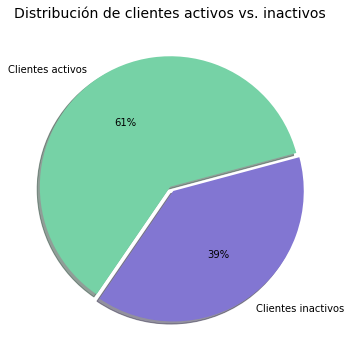

In [32]:
my_labels = 'Clientes activos', 'Clientes inactivos'
my_explode = (0, 0.04)
ax = commercial_df[commercial_df["pk_partition"] == "2019-05-28"].groupby('active_customer').size().plot(kind='pie',
                                                                                                         labels=my_labels,
                                                                                                         startangle=15,
                                                                                                         autopct='%1.0f%%',
                                                                                                         figsize=(6, 6),
                                                                                                         shadow=True,
                                                                                                         colors=[
                                                                                                             '#76d2a6',
                                                                                                             "#8276d2"],
                                                                                                         explode=my_explode)
ax.set_title("Distribución de clientes activos vs. inactivos", fontsize=14)
plt.ylabel("")
plt.show()

#### Categóricas
*   Pk_cid
*   Entry_channel
*   Segment



##### Entry_channel


In [33]:
commercial_df["entry_channel"].value_counts().tail(20)

KCL    17
KBE    17
KBH    17
KFK    17
KGN    17
KCI    17
KGX    17
KDR    16
KFL    13
KBW    12
KBU    11
KAI    11
KCK    11
KBY    11
KES    11
KEJ     8
KHS     5
KDA     2
KFP     2
KDS     1
Name: entry_channel, dtype: int64

In [34]:
##### Tratamiento de nulos de la variable Entry_channel

In [35]:
df["entry_channel"].fillna(-1, inplace=True)

In [36]:
commercial_df["entry_channel"].fillna(-1, inplace=True)

In [37]:
commercial_df["entry_channel"].isnull().sum()

0

##### Segment
Segmento comercial del cliente

###### Tratamiento de nulos de la variable Segment

In [38]:
commercial_df["segment"].fillna(-1, inplace=True)

In [39]:
df["segment"].fillna(-1, inplace=True)

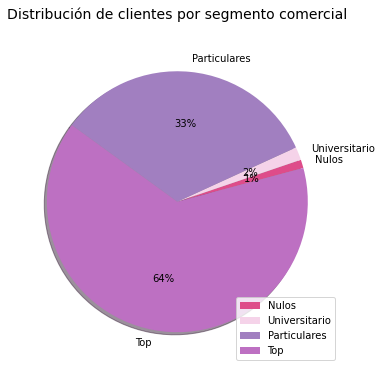

In [40]:
my_labels = ["Nulos", "Universitario", "Particulares", "Top"]
ax = commercial_df[commercial_df["pk_partition"] == "2019-05-28"].groupby('segment').size().plot(kind='pie',
                                                                                                 startangle=15,
                                                                                                 labels=my_labels,
                                                                                                 autopct='%1.0f%%',
                                                                                                 figsize=(6, 6),
                                                                                                 shadow=True,
                                                                                                 colors=["#de4c8a",
                                                                                                         '#f5d3e9',
                                                                                                         "#A17FC0",
                                                                                                         "#BD70C2"])
ax.set_title("Distribución de clientes por segmento comercial", fontsize=14, loc='center', pad=20)
ax.legend(loc='lower right')
plt.ylabel("")
plt.show()

### Exploración del dataset "Products_df"

In [41]:
skewness(products_df)

             Atributos  val_únicos    Skewness
9        em_account_pp           1  100.000000
16        em_account_p           2   99.999430
5             mortgage           2   99.994566
4                loans           2   99.992152
3   short_term_deposit           2   99.741838
6                funds           2   99.662934
7           securities           2   99.628823
10         credit_card           2   98.811556
8    long_term_deposit           2   98.311902
11             payroll           2   96.548856
12        pension_plan           2   96.347359
14         emc_account           2   94.516767
13     payroll_account           2   94.475529
15          debit_card           2   90.558860


,Atributos,val_únicos,Skewness
9,em_account_pp,1,100.000000
16,em_account_p,2,99.999430
5,mortgage,2,99.994566
4,loans,2,99.992152
3,short_term_deposit,2,99.741838
6,funds,2,99.662934
7,securities,2,99.628823
10,credit_card,2,98.811556
8,long_term_deposit,2,98.311902
11,payroll,2,96.548856


In [42]:
products_df.head()

,Unnamed: 0,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [43]:
products_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Columns: 18 entries, Unnamed: 0 to em_acount
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB


In [44]:
#Hacemos un drop del atributo "Unnamed: 0" ya que no aporta ninguna información.
products_df.drop('Unnamed: 0', axis=1, inplace=True)

In [45]:
len(products_df.columns)

17

In [46]:
#Buscamos cuáles son los campus que contienen nulos.
products_df.isnull().sum()

pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [47]:
nulos = ["entry_channel", "segment", "payroll", "payroll"]

In [48]:
products_df.describe()

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
count,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5962924.0,5.962924e+06,5.962863e+06,5.962863e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06
mean,1.234930e+06,2.581619e-03,7.848498e-05,5.433576e-05,3.370662e-03,3.711770e-03,1.688098e-02,0.0,1.188444e-02,3.451144e-02,3.652641e-02,5.524471e-02,5.483233e-02,9.441140e-02,5.701901e-06,7.348076e-01
std,1.623020e+05,5.074401e-02,8.858828e-03,7.371080e-03,5.795948e-02,6.081113e-02,1.288255e-01,0.0,1.083660e-01,1.825388e-01,1.875960e-01,2.284573e-01,2.276527e-01,2.924002e-01,2.387859e-03,4.414356e-01
min,1.589100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.112532e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.231097e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.352339e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.553689e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [49]:
products_df.shape

(5962924, 17)

In [50]:
#Comprovamos si el dataframe contiene registros duplicados
products_df[products_df.duplicated(keep=False)]

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount


In [51]:
#Observamos el tipo de datos que contiene el data set
products_df.dtypes

pk_cid                  int64
pk_partition           object
short_term_deposit      int64
loans                   int64
mortgage                int64
funds                   int64
securities              int64
long_term_deposit       int64
em_account_pp           int64
credit_card             int64
payroll               float64
pension_plan          float64
payroll_account         int64
emc_account             int64
debit_card              int64
em_account_p            int64
em_acount               int64
dtype: object

#### Fechas 


*   pk_partition



#### Categóricas

*   pk_cid



#### Booleanas



*   credit_card
*   debit_card
*   em_account_p
*   em_account_pp
*   em_acount 
*   emc_account
*   funds
*   loans
*   long_term_deposit
*   mortgage
*   payroll
*   payroll_account
*   pension_plan
*   securities
*   short_term_deposit 

















Productos de ahorro e inversión
- Pension_plan
- Securities
- Funds
- Long_term_deposit
- Short_term_deposit


Productos de financiación
- Mortgage
- Loans
- Credit_card




In [52]:
#Creamos una nueva columna que agrupe los productos de ahorra e inversión
df["InvestmentProducts"] = df["pension_plan"] + df["securities"] + df["funds"] + df["long_term_deposit"] + df[
    "short_term_deposit"]

In [53]:
df["InvestmentProducts"].value_counts()

0.0    5608840
1.0     333841
2.0      18450
3.0       1581
4.0        151
Name: InvestmentProducts, dtype: int64

In [54]:
df["InvestmentProducts"].replace([2, 3, 4, 5], 1, inplace=True)

In [55]:
#De todos los registros de clientes que tenemos, solamente un 0.06% han adquirido un producto de inversión.
df["InvestmentProducts"].value_counts(normalize=True)

0.0    0.940629
1.0    0.059371
Name: InvestmentProducts, dtype: float64

In [56]:
# Creamos una nueva columna que incluya los productos de financiacón
df["FinancialProducts"] = df["mortgage"] + df["loans"] + df["credit_card"]

In [57]:
df["FinancialProducts"].value_counts()

0    5891611
1      70968
2        345
Name: FinancialProducts, dtype: int64

In [58]:
df["FinancialProducts"].replace([2, 3], 1, inplace=True)

In [59]:
# Un 0.01% de nuestros registros de clientes, ha adquirido algún tipo de producto de financiación
df["FinancialProducts"].value_counts(normalize=True)

0    0.988041
1    0.011959
Name: FinancialProducts, dtype: float64

##### Credit_card
Tarjetas de crédito

In [60]:
#Seleccionamos el dataset que contienen los valores "True" para visualizarlos posteriormente
credit_card_1 = df[df["credit_card"] == 1 & (df["pk_partition"] == "2019-05-28")]

##### Creación de una pivot table para ver la cantidad de tarjetas de crédito a nivel mensual

In [61]:
credit_card_table = pd.pivot_table(data=df, index=["pk_partition_Year", "pk_partition_Month"], values=["credit_card"],
                                   aggfunc=[sum, np.mean])

In [62]:
credit_card_table

sum        mean
                                     credit_card credit_card
pk_partition_Year pk_partition_Month                        
2018              1                         3325    0.013883
                  2                         3282    0.013533
                  3                         3511    0.014316
                  4                         3725    0.015053
                  5                         3797    0.015192
                  6                         4002    0.015874
                  7                         4137    0.012191
                  8                         4206    0.011918
                  9                         4289    0.011427
                  10                        4385    0.010900
                  11                        4512    0.010836
                  12                        4536    0.010737
2019              1                         4493    0.010525
                  2                         4542    0.010521
                  3                         4576    0.010491
                  4                         4747    0.010798
                  5                         4801    0.010838

##### Debit_card
Tarjetas de débito

In [63]:
#Seleccionamos el dataset que contienen los valores "True" para visualizarlos posteriormente
debit_card_1 = df[(df["debit_card"] == 1) & (df["pk_partition"] == "2019-05-28")]

In [64]:
#Existen 46116 clientes que tienen una tarjeta de crédito y de débito 
len(df[(df["debit_card"] == 1) & (df["credit_card"] == 1)])

46116

In [65]:
#Existen 5375206 clientes que no tienen ni una tarjeta de crédito ni una tarjeta de débito, corresponde al 90% de los clientes.
len(df[(df["debit_card"] == 0) & (df["credit_card"] == 0)])

5375206

##### Creación de una pivot table para ver la cantidad de tarjetas de débito a nivel mensual

In [66]:
debit_card_table = pd.pivot_table(data=df, index=["pk_partition_Year", "pk_partition_Month"], values=["debit_card"],
                                  aggfunc=[sum, np.mean])

In [67]:
debit_card_table

sum       mean
                                     debit_card debit_card
pk_partition_Year pk_partition_Month                      
2018              1                       24696   0.103118
                  2                       25448   0.104931
                  3                       27046   0.110276
                  4                       27764   0.112195
                  5                       27911   0.111677
                  6                       28828   0.114350
                  7                       29578   0.087164
                  8                       29205   0.082752
                  9                       31684   0.084418
                  10                      34372   0.085439
                  11                      35466   0.085176
                  12                      37430   0.088596
2019              1                       37350   0.087496
                  2                       39399   0.091259
                  3                       41390   0.094891
                  4                       42140   0.095854
                  5                       43261   0.097656

##### Visualización del número de tarjetas de crédito vs. tarjetas de débito

Observamos que solamente el 11% de los clientes disponen de una tarjeta de crédito. Sin embargo, debemos considerar que un cliente puede tener una tarjeta de crédito y una tarjeta de débito. En este caso, nos encontramos que 46116 clientes disponen de ambas. Es decir, el 65% de los clientes que tienen una tarjeta de crédito, disponen también de una tarjeta de débito.

In [68]:
type_df = [['Tarjetas de crédito', len(credit_card_1)], ['Tarjetas de débito', len(debit_card_1)]]
type_df = pd.DataFrame(type_df, columns=['Tipo de tarjeta', 'Column count']).sort_values('Column count', ascending=True)

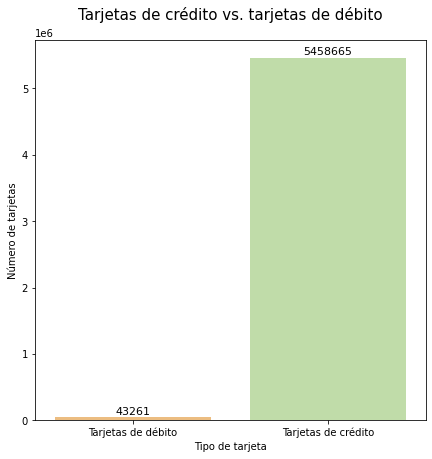

In [69]:
f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x="Tipo de tarjeta", y="Column count", data=type_df, label="Missing", palette='Spectral')
ax.set_ylabel('Número de tarjetas', fontsize=10, color='k')
ax.set_title('Tarjetas de crédito vs. tarjetas de débito', fontsize=15, color='k', pad=20)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom',
                fontsize=11)
plt.show

plt.show()

##### Em_account_p

In [70]:
#Seleccionamos el dataset que contienen los valores "True" para visualizarlos posteriormente
em_account_p_1 = products_df[products_df["em_account_p"] == 1]

##### Em_account_pp

In [71]:
#Seleccionamos el dataset que contienen los valores "True" para visualizarlos posteriormente
em_account_pp_1 = products_df[products_df["em_account_pp"] == 1]

##### Em_acount

In [72]:
#Seleccionamos el dataset que contienen los valores "True" para visualizarlos posteriormente
em_acount_1 = products_df[products_df["em_acount"] == 1]

##### Emc_account

In [73]:
#Seleccionamos el dataset que contienen los valores "True" para visualizarlos posteriormente
emc_account_1 = products_df[products_df["emc_account"] == 1]

##### Payroll_account

In [74]:
#Seleccionamos el dataset que contienen los valores "True" para visualizarlos posteriormente
payroll_account_1 = products_df[products_df["payroll_account"] == 1]

##### Creación nueva columna que indique si el registro tiene una cuenta 

In [75]:
#Creamos una nueva columna, sumando el resultado de todas las columnas del clientes
df["HasAccount"] = df["em_account_p"] + df["em_account_pp"] + df["em_acount"] + df["emc_account"] + df[
    "payroll_account"]

In [76]:
#Observamos que existen personas que tenga 0,1,2 o hasta 3 cuentas diferentes.
df["HasAccount"].value_counts(normalize=True)

1    0.762255
0    0.196789
2    0.040233
3    0.000723
Name: HasAccount, dtype: float64

In [77]:
df["HasAccount"].replace([2, 3], 1, inplace=True)

In [78]:
#Existe un 19.6% de los registros que no tiene una cuenta. 
df["HasAccount"].value_counts(normalize=True)

1    0.803211
0    0.196789
Name: HasAccount, dtype: float64

##### Creación nueva columna que indique si el registro ha realizado alguna compra (producto de financiación, producto de inversión o cuenta bancária.

In [79]:
df["HasBought"] = df["HasAccount"] + df["InvestmentProducts"] + df["FinancialProducts"]

In [80]:
#Un registro puede tener hasta un máximo de 3 ventas que significaría que ha comprado un producto de inversión, un producto de financiación y además tiene una cuenta bancária (como mínimo).
df["HasBought"].value_counts(normalize=False)

1.0    4472815
0.0    1136109
2.0     319809
3.0      34130
Name: HasBought, dtype: int64

In [81]:
df["HasBought"].replace([2, 3], 1, inplace=True)

In [82]:
#El 80,9% de los clientes ha comprado 
df["HasBought"].value_counts(normalize=True)

1.0    0.809469
0.0    0.190531
Name: HasBought, dtype: float64

##### Visualización de los tipos de cuenta

In [83]:
cuentas_df = [['Cuenta easyMoney+', len(em_account_p_1)], ['Cuenta easyMoney', len(em_acount_1)],
              ['Cuenta easyMoney Crypto', len(emc_account_1)], ["Cuenta Payroll", len(payroll_account_1)]]
cuentas_df = pd.DataFrame(cuentas_df, columns=['Tipos de cuenta', 'Column count']).sort_values('Column count',
                                                                                               ascending=True)

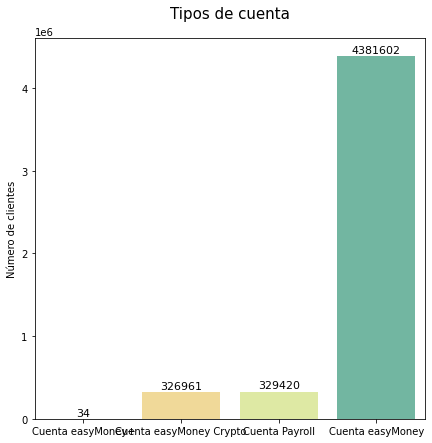

In [84]:
f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x="Tipos de cuenta", y="Column count", data=cuentas_df, label="Missing", palette='Spectral')
ax.set_ylabel('Número de clientes', fontsize=10, color='k')
ax.set_xlabel('')
ax.set_title('Tipos de cuenta', fontsize=15, color='k', pad=20)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom',
                fontsize=11)
plt.show()

##### Estadísticos por tipo de cuentas

##### Long_term_deposit

In [85]:
#Seleccionamos el dataset que contienen los valores "True" para visualizarlos posteriormente
long_term_deposit_1 = products_df[products_df["long_term_deposit"] == 1]

##### Short_term_deposit

In [86]:
#Seleccionamos el dataset que contienen los valores "True" para visualizarlos posteriormente
short_term_deposit_1 = products_df[products_df["short_term_deposit"] == 1]

###### Visualización del número de long_term_deposit versus el número de short_term_deposit

In [87]:
deposit_df = [['Long-term deposit', len(long_term_deposit_1)], ['Short-term deposit', len(short_term_deposit_1)]]
deposit_df = pd.DataFrame(deposit_df, columns=['Tipo de depósito', 'Column count']).sort_values('Column count',
                                                                                                ascending=True)

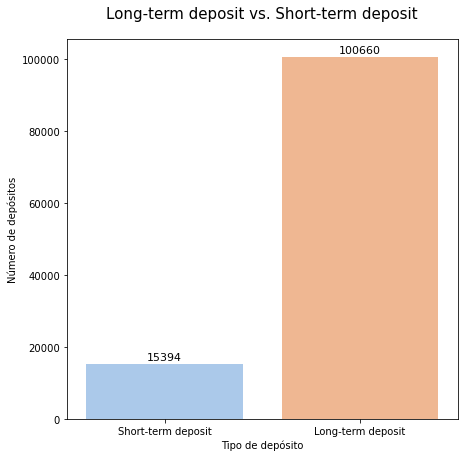

In [88]:
f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x="Tipo de depósito", y="Column count", data=deposit_df, label="Missing", palette='pastel')
ax.set_ylabel('Número de depósitos', fontsize=10, color='k')
ax.set_title('Long-term deposit vs. Short-term deposit', fontsize=15, color='k', pad=20)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom',
                fontsize=11)
plt.show

plt.show()

##### Payroll

In [89]:
products_df["payroll"].value_counts()

0.0    5757076
1.0     205787
Name: payroll, dtype: int64

###### Tratamiento de nulos de la variable "Payroll"

In [90]:
df["payroll"].isnull().sum()

61

In [91]:
df.dropna(subset=['payroll'], inplace=True)

In [92]:
products_df.dropna(subset=['payroll'], inplace=True)

In [93]:
products_df["payroll"].isnull().sum()

0

In [94]:
df["payroll"].isnull().sum()

0

##### Pension_plan

In [95]:
df["pension_plan"].value_counts()

0.0    5745061
1.0     217802
Name: pension_plan, dtype: int64

### Exploración del dataset "Sociodemographic_df"


In [96]:
sociodemographic_df["pk_partition"].unique()

array(['2018-01-28', '2018-02-28', '2018-03-28', '2018-04-28',
       '2018-05-28', '2018-06-28', '2018-07-28', '2018-08-28',
       '2018-09-28', '2018-10-28', '2018-11-28', '2018-12-28',
       '2019-01-28', '2019-02-28', '2019-03-28', '2019-04-28',
       '2019-05-28'], dtype=object)

In [97]:
skewness(sociodemographic_df)

    Atributos  val_únicos   Skewness
7    deceased           2  99.981972
3  country_id          41  99.962233


,Atributos,val_únicos,Skewness
7,deceased,2,99.981972
3,country_id,41,99.962233


In [98]:
sociodemographic_df.head()

,Unnamed: 0,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,0,1375586,2018-01-28,ES,29.0,H,35,N,87218.10
1,1,1050611,2018-01-28,ES,13.0,V,23,N,35548.74
2,2,1050612,2018-01-28,ES,13.0,V,23,N,122179.11
3,3,1050613,2018-01-28,ES,50.0,H,22,N,119775.54
4,4,1050614,2018-01-28,ES,50.0,V,23,N,NaN


In [99]:
sociodemographic_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Columns: 9 entries, Unnamed: 0 to salary
dtypes: float64(2), int64(3), object(4)
memory usage: 409.4+ MB


In [100]:
#Hacemos un drop del atributo "Unnamed: 0" ya que no aporta ninguna información.
sociodemographic_df.drop('Unnamed: 0', axis=1, inplace=True)

In [101]:
#Buscamos cuáles son los campus que contienen nulos.
sociodemographic_df.isnull().sum()

pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1512103
dtype: int64

In [102]:
#Añadimos las variables que contienen nulos 
nulos = ["entry_channel", "segment", "payroll", "pension_plan", "region_code", "gender", "salary"]

In [103]:
sociodemographic_df.describe()

,pk_cid,region_code,age,salary
count,5.962924e+06,5.960660e+06,5.962924e+06,4.450821e+06
mean,1.234930e+06,2.581440e+01,2.976042e+01,1.158167e+05
std,1.623020e+05,1.359566e+01,1.198038e+01,1.995519e+05
min,1.589100e+04,1.000000e+00,2.000000e+00,1.202730e+03
25%,1.112532e+06,1.300000e+01,2.200000e+01,6.150063e+04
50%,1.231097e+06,2.800000e+01,2.500000e+01,8.865465e+04
75%,1.352339e+06,3.600000e+01,3.400000e+01,1.316699e+05
max,1.553689e+06,5.200000e+01,1.050000e+02,2.889440e+07


In [104]:
len(sociodemographic_df.columns)

8

In [105]:
sociodemographic_df.shape

(5962924, 8)

In [106]:
#Verficiamos que no existen entradas duplicadas
sociodemographic_df[sociodemographic_df.duplicated(keep=False)]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary


In [107]:
#Observamos el tipo de datos que contiene el data set
sociodemographic_df.dtypes

pk_cid            int64
pk_partition     object
country_id       object
region_code     float64
gender           object
age               int64
deceased         object
salary          float64
dtype: object

#### Fechas 


*   Pk_partition



#### Categóricas 
*   pk_cid
*   country_id
*   region_code





##### Country_id

In [108]:
sociodemographic_df["country_id"].value_counts()

ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: country_id, dtype: int64

In [109]:
df["country_id"] = other_selection(df, "country_id", 1)
sociodemographic_df["country_id"] = other_selection(df, "country_id", 1)

In [110]:
df["country_id"].value_counts()

ES        5960611
Others       2252
Name: country_id, dtype: int64

##### Region_code

In [111]:
df["region_code"].value_counts()

28.0    1185744
8.0      600359
46.0     358137
30.0     296855
41.0     290442
15.0     254890
29.0     187909
36.0     175850
3.0      171357
11.0     160893
33.0     134561
50.0     132982
6.0      122587
35.0     121981
47.0     116948
18.0     102787
45.0     102326
37.0      92537
10.0      83283
14.0      75404
2.0       72071
21.0      72037
13.0      70091
39.0      69588
12.0      68708
7.0       62436
32.0      54639
27.0      52783
43.0      51780
17.0      50748
9.0       47744
25.0      46885
16.0      36094
24.0      35424
48.0      35256
26.0      34789
4.0       32680
31.0      31241
49.0      30965
23.0      30954
38.0      29001
34.0      27545
19.0      26762
40.0      21658
5.0       21300
22.0      21112
20.0      18833
1.0       12998
44.0      12616
42.0       8500
51.0       2896
52.0       2633
Name: region_code, dtype: int64

#### Numéricas

*   Age
*   Salary




##### Age
Edad del cliente

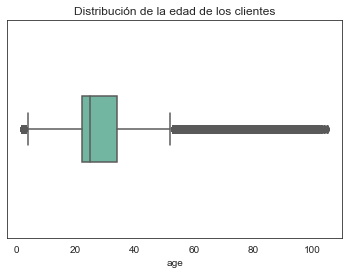

In [112]:
sns.set_style("white")
sns.boxplot(x='age', data=sociodemographic_df, width=0.3, palette="Set2", linewidth=1.5, ).set(
    title='Distribución de la edad de los clientes')
plt.show()

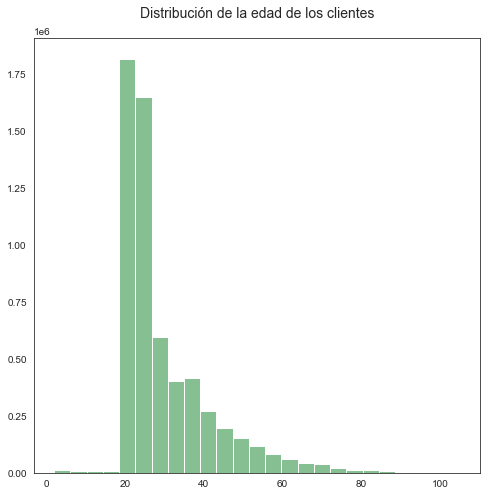

In [113]:
ax = sociodemographic_df.hist(column='age', bins=25, grid=False, figsize=(8, 8), color='#86bf91', zorder=2, rwidth=1.5)
plt.title('Distribución de la edad de los clientes', fontsize=14, pad=20)
plt.show()

##### Salary
Ingresos brutos de la unidad familiar 

In [114]:
sociodemographic_df["salary"].value_counts().head()

451931.22    760
288997.44    546
135522.15    466
128318.52    458
104563.80    436
Name: salary, dtype: int64

###### Tratamiento de nulos de la variable Salary

In [115]:
#Substituímos los valores por un salario extremo como puede ser -1.
sociodemographic_df["salary"].fillna(-1, inplace=True)

In [116]:
df["salary"].fillna(-1, inplace=True)

In [117]:
df["salary"].isnull().sum()

0

#### Booleanas
*   deceased
*   gender



##### Gender
Género del cliente

La distribución del género de nuestra base de clientes es prácticamente equitativa con un 52% de hombres y un 48% de mujeres.

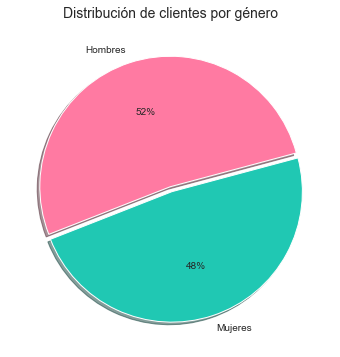

In [118]:
my_labels = ["Hombres", "Mujeres"]
my_explode = (0, 0.04)
ax = sociodemographic_df.groupby('gender').size().plot(kind='pie', startangle=15, labels=my_labels, autopct='%1.0f%%',
                                                       figsize=(6, 6), shadow=True, colors=['#FF7AA2', "#20c8b3"],
                                                       explode=my_explode)
ax.set_title("Distribución de clientes por género", fontsize=14)
plt.ylabel("")
plt.show()

In [119]:
sociodemographic_df.dropna(subset=['gender'], inplace=True)

In [120]:
df.dropna(subset=['gender'], inplace=True)

In [121]:
df["gender"].isnull().sum()

0

##### Deceased

In [122]:
sociodemographic_df["deceased"].value_counts()

N    5961824
S       1075
Name: deceased, dtype: int64

### Visualizaciones y análisis multivariante

#### Distribución de las edades según el género 

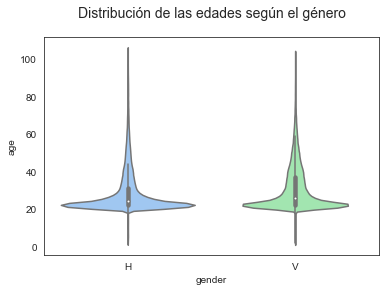

In [123]:
ax = sns.violinplot(data=df, x='gender', y='age', figsize=(6, 6))
ax.set_title("Distribución de las edades según el género", fontsize=14, pad=20)
plt.show()

#### Visualización de las edades de los cientes que tienen un plan de pensión. 

<AxesSubplot:>

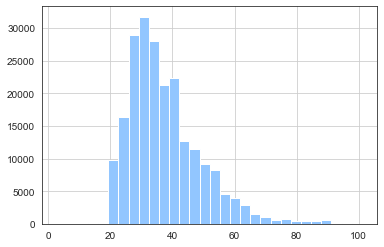

In [124]:
df.loc[df["pension_plan"] == 1, "age"].hist(bins=30)

#### Visualización de las edades de los cientes que tienen hipotecas. 

<AxesSubplot:>

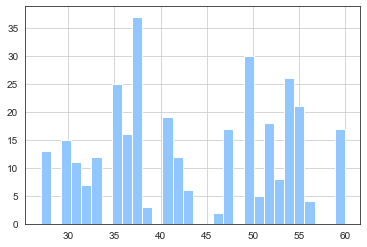

In [125]:
df.loc[df["mortgage"] == 1, "age"].hist(bins=30)

#### Visualización de las edades de los cientes que tienen productos de inversión. 

<AxesSubplot:>

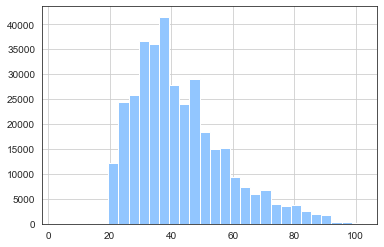

In [126]:
df.loc[df["InvestmentProducts"] == 1, "age"].hist(bins=30)

#### Ventas de productos de financiación

In [127]:
Ventas_FinancialProducts = pd.pivot_table(data=df, index=["pk_partition_Year", "pk_partition_Month"],
                                          values=["credit_card", "mortgage", "loans", "FinancialProducts"],
                                          aggfunc=[sum, len, np.median])

In [128]:
Ventas_FinancialProducts

sum                    \
                                     FinancialProducts credit_card loans   
pk_partition_Year pk_partition_Month                                       
2018              1                               3342        3325    19   
                  2                               3301        3282    19   
                  3                               3536        3511    23   
                  4                               3751        3725    24   
                  5                               3825        3797    27   
                  6                               4030        4002    27   
                  7                               4168        4137    28   
                  8                               4234        4206    29   
                  9                               4316        4289    31   
                  10                              4415        4385    33   
                  11                              4540        4512    32   
                  12                              4561        4536    30   
2019              1                               4518        4493    28   
                  2                               4566        4542    29   
                  3                               4601        4576    29   
                  4                               4778        4747    30   
                  5                               4831        4801    30   

                                                            len              \
                                     mortgage FinancialProducts credit_card   
pk_partition_Year pk_partition_Month                                          
2018              1                        15            239476      239476   
                  2                        15            242507      242507   
                  3                        17            245247      245247   
                  4                        17            247452      247452   
                  5                        18            249915      249915   
                  6                        19            252103      252103   
                  7                        20            339338      339338   
                  8                        20            352920      352920   
                  9                        20            375321      375321   
                  10                       19            402298      402298   
                  11                       19            416385      416385   
                  12                       19            422479      422479   
2019              1                        20            426873      426873   
                  2                        20            431725      431725   
                  3                        20            436181      436181   
                  4                        23            439625      439625   
                  5                        23            442993      442993   

                                                                 median  \
                                       loans mortgage FinancialProducts   
pk_partition_Year pk_partition_Month                                      
2018              1                   239476   239476                 0   
                  2                   242507   242507                 0   
                  3                   245247   245247                 0   
                  4                   247452   247452                 0   
                  5                   249915   249915                 0   
                  6                   252103   252103                 0   
                  7                   339338   339338                 0   
                  8                   352920   352920                 0   
                  9                   375321   375321                 0   
                  10                  402298   40

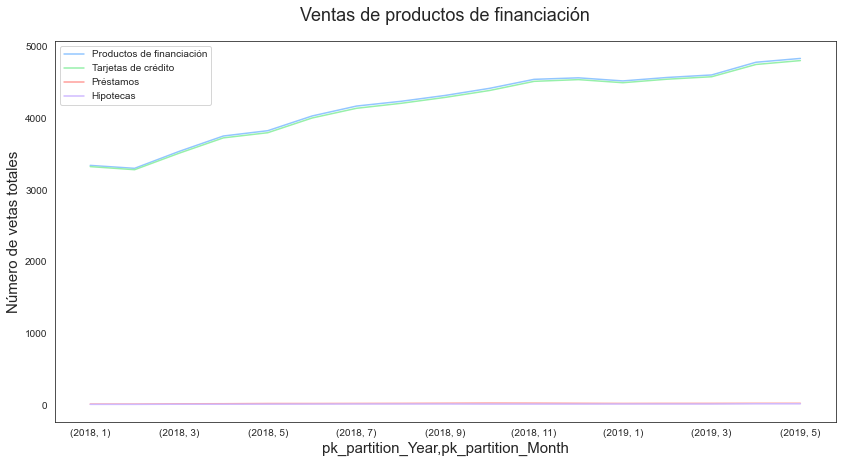

In [129]:
plt.figure(figsize=[14, 7])
plt.title("Ventas de productos de financiación", fontsize=18, pad=20)
plt.xlabel("Fecha de la venta", fontsize=15)
plt.ylabel("Número de vetas totales", fontsize=15)
Ventas_FinancialProducts[("sum", "FinancialProducts")].plot(kind="line", label="Productos de financiación")
Ventas_FinancialProducts[("sum", "credit_card")].plot(kind="line", label="Tarjetas de crédito")
Ventas_FinancialProducts[("sum", "loans")].plot(kind="line", label="Préstamos")
Ventas_FinancialProducts[("sum", "mortgage")].plot(kind="line", label="Hipotecas")
plt.legend()
plt.show()

#### Ventas de productos de inversión

In [130]:
Ventas_InvestmentProducts = pd.pivot_table(data=df, index=["pk_partition_Year", "pk_partition_Month"],
                                           values=["funds", "long_term_deposit", "short_term_deposit", "securities",
                                                   "InvestmentProducts", "pension_plan"], aggfunc=[sum, len, np.median])

In [131]:
Ventas_InvestmentProducts

sum        \
                                     InvestmentProducts funds   
pk_partition_Year pk_partition_Month                            
2018              1                             15371.0   786   
                  2                             16596.0   872   
                  3                             17364.0   969   
                  4                             18275.0  1084   
                  5                             17947.0  1145   
                  6                             19417.0  1159   
                  7                             20820.0  1172   
                  8                             20473.0  1219   
                  9                             21256.0  1237   
                  10                            22140.0  1249   
                  11                            22483.0  1282   
                  12                            23806.0  1322   
2019              1                             20942.0  1330   
                  2                             23516.0  1316   
                  3                             24150.0  1322   
                  4                             24270.0  1320   
                  5                             25197.0  1315   

                                                                     \
                                     long_term_deposit pension_plan   
pk_partition_Year pk_partition_Month                                  
2018              1                               4884       8835.0   
                  2                               4956       9496.0   
                  3                               4965       9882.0   
                  4                               5107      10560.0   
                  5                               5356      10148.0   
                  6                               5588      11635.0   
                  7                               5796      12779.0   
                  8                               5923      12126.0   
                  9                               6158      12624.0   
                  10                              6380      13223.0   
                  11                              6447      13818.0   
                  12                              6749      15324.0   
2019              1                               6659      12538.0   
                  2                               6658      15265.0   
                  3                               6537      15976.0   
                  4                               6368      16220.0   
                  5                               6129      17353.0   

                                                                    \
                                     securities short_term_deposit   
pk_partition_Year pk_partition_Month                                 
2018              1                         932                883   
                  2                         965               1343   
                  3                         965               1664   
                  4                         983               1740   
                  5                        1012               1455   
                  6                        1019               1244   
                  7                        1053               1282   
                  8                        1133               1335   
                  9                        1201               1386   
                  10                       1348               1374   
                  11                       1360               1018   
                  12                       1420                528   
2019              1                        1655                125   
                  2                        1747                 11   
                  3                        1769                  2   
                  4                        1782                  2   


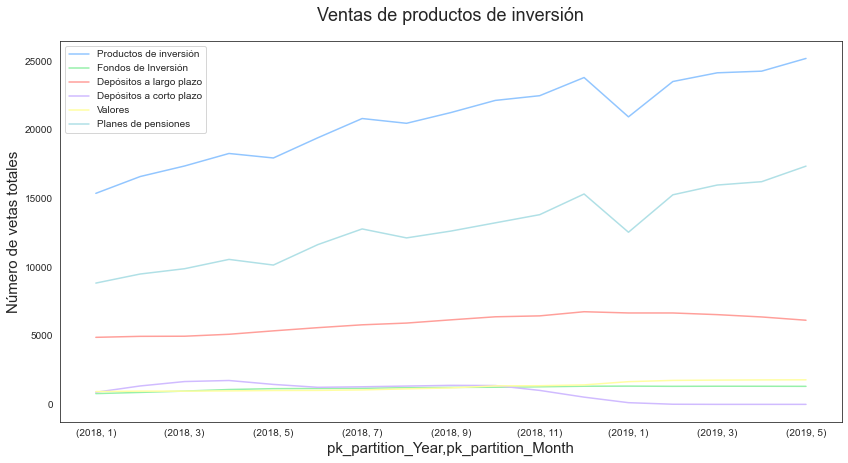

In [132]:
plt.figure(figsize=[14, 7])
plt.title("Ventas de productos de inversión", fontsize=18, pad=20)
plt.xlabel("Fecha de la venta", fontsize=15)
plt.ylabel("Número de vetas totales", fontsize=15)
Ventas_InvestmentProducts[("sum", "InvestmentProducts")].plot(kind="line", label="Productos de inversión")
Ventas_InvestmentProducts[("sum", "funds")].plot(kind="line", label="Fondos de Inversión")
Ventas_InvestmentProducts[("sum", "long_term_deposit")].plot(kind="line", label="Depósitos a largo plazo")
Ventas_InvestmentProducts[("sum", "short_term_deposit")].plot(kind="line", label="Depósitos a corto plazo")
Ventas_InvestmentProducts[("sum", "securities")].plot(kind="line", label="Valores")
Ventas_InvestmentProducts[("sum", "pension_plan")].plot(kind="line", label="Planes de pensiones")
plt.legend()
plt.show()

## ALFREDO

In [144]:
def get_max_consecutive(serie: pd.Series) -> int:
    """
    Obtiene el maximo de meses consecutivos
    :param serie: serie de booleanos que determinan si ese mes estuvo activo
    :return: maximo de meses consecutivos
    """

    counter = 0
    segments = [0]
    for i in serie:
        if i == 1:
            counter += 1
        elif counter > 0:
            segments.append(counter)
            counter = 0

    if counter > 0:
        segments.append(counter)

    return np.array(segments).max()


def get_month_active(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Obtiene la cantidad de meses consecutivos que un cliente estuvo activo y su clasificacion en los 17 meses del dataset
    :param dataframe: dataframe a evaluar
    :return: pd.Series con la cantidad de meses consecutivos y su clasificacion
    """

    result = { "month_active": get_max_consecutive(dataframe['active_customer']) }

    return pd.DataFrame(result, index=["month_active"])


In [149]:
gb = df.groupby("pk_cid")

In [151]:
gb.get_group(17457)

,Unnamed: 0_x,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,Unnamed: 0_y,country_id,region_code,...,entry_date_Trim,pk_partition_Month,pk_partition_Year,pk_partition_Week,pk_partition_Weekday,pk_partition_Trim,InvestmentProducts,FinancialProducts,HasAccount,HasBought
237929,417555,17457,2018-01-28,2017-09-16,KAT,1.0,02 - PARTICULARES,417555,ES,28.0,...,3,1,2018,4,6,1,1.0,0,1,1.0
241166,835582,17457,2018-02-28,2017-09-16,KAT,1.0,02 - PARTICULARES,835582,ES,28.0,...,3,2,2018,9,2,1,1.0,0,1,1.0
586811,1673319,17457,2018-03-28,2017-09-16,KAT,1.0,02 - PARTICULARES,1673319,ES,28.0,...,3,3,2018,13,2,1,1.0,0,1,1.0
728998,2091540,17457,2018-04-28,2017-09-16,KAT,1.0,02 - PARTICULARES,2091540,ES,28.0,...,3,4,2018,17,5,2,1.0,0,1,1.0
1222865,2934362,17457,2018-05-28,2017-09-16,KAT,1.0,02 - PARTICULARES,2934362,ES,28.0,...,3,5,2018,22,0,2,1.0,0,1,1.0
1474919,3566422,17457,2018-06-28,2017-09-16,KAT,1.0,02 - PARTICULARES,3566422,ES,28.0,...,3,6,2018,26,3,2,1.0,0,1,1.0
1479564,4079275,17457,2018-07-28,2017-09-16,KAT,1.0,02 - PARTICULARES,4079275,ES,28.0,...,3,7,2018,30,5,3,1.0,0,1,1.0
2168118,5318497,17457,2018-08-28,2017-09-16,KAT,1.0,02 - PARTICULARES,5318497,ES,28.0,...,3,8,2018,35,1,3,1.0,0,1,1.0
2171487,5704520,17457,2018-09-28,2017-09-16,KAT,1.0,02 - PARTICULARES,5704520,ES,28.0,...,3,9,2018,39,4,3,1.0,0,1,1.0
2943632,6909489,17457,2018-10-28,2017-09-16,KAT,1.0,02 - PARTICULARES,6909489,ES,28.0,...,3,10,2018,43,6,4,0.0,0,1,1.0


In [148]:
%%time
GENERATE_MONTH_ACTIVE_DF = True

if GENERATE_MONTH_ACTIVE_DF:
    month_active_df = df.groupby("pk_cid").apply(get_max_consecutive)
    month_active_df.to_csv("../data/interim/month_active_df.csv")
else:
    month_active_df = pd.read_csv("../data/interim/month_active_df.csv")

month_active_df.info()

AttributeError: 'Series' object has no attribute 'info'

<AxesSubplot:>

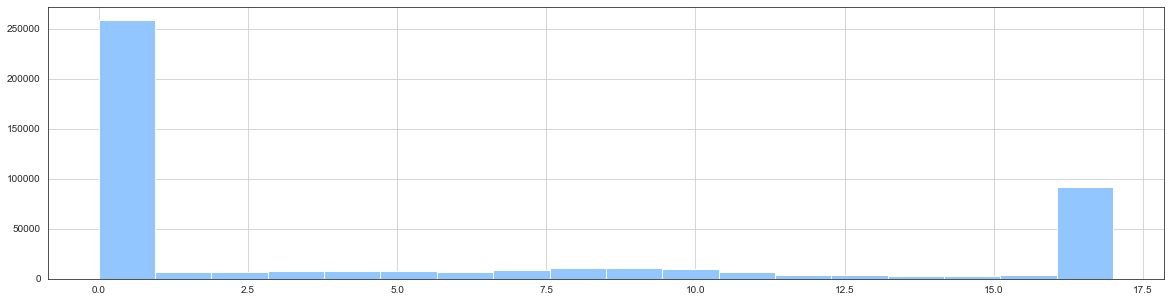

In [135]:
month_active_df["month_active"].hist(figsize=(20, 5), bins=18)

In [136]:
print(
    f"Cantidad de clientes que tienen estado activo por 17 meses: {len(month_active_df[month_active_df['month_active'] == 17])}")

Cantidad de clientes que tienen estado activo por 17 meses: 91896
